# 1. Install Dependencies

In [ ]:
%pip install gymnasium
%pip install 'gymnasium[atari]'
%pip install 'gymnasium[accept-rom-license]'
%pip install 'shimmy>=0.2.1'
%pip install torch torchvision torchaudio
%pip install matplotlib
%pip install tensorboard
%pip install 'stable-baselines3[extra]>=2.0.0a4'
%pip install scikit-image

# 2. Import Dependencies

In [1]:
import gymnasium
from gymnasium import spaces
from gymnasium.spaces import Box

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output

import time
import numpy as np
from skimage.transform import resize

import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Module

from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [2]:
# Change to True if you want to run on Kaggle
# Also, the underground model should be uploaded to Kaggle
KAGGLE = False

# 3. Utils

### Modelo de previsão se o jogador está debaixo de terra

In [3]:
class UndergroundModel(Module):
    def __init__(self):
        super(UndergroundModel, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=10, stride=1, padding=2)
        self.conv2 = Conv2d(16, 32, kernel_size=10, stride=1, padding=1)
        self.conv3 = Conv2d(32, 64, kernel_size=7, stride=1, padding=1)
        self.fc1 = Linear(7744, 16)
        self.fc2 = Linear(16, 16)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.relu = ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Funções para correr e criar gif de uma execução do ambiente

In [4]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        print(f"Comulative Reward: {experience['com_reward']}")
        
        # Pause animation
        time.sleep(time_lag)

In [5]:
def store_episode_as_gif(experience_buffer, filepath='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set frames per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(filepath, writer='imagemagick', fps=fps)

# 4. Create Base Environment

### Ambiente base do Pitfall!, versão de observações de RAM

In [6]:
base_env = gymnasium.make('ALE/Pitfall-ram-v5', render_mode='rgb_array')
if base_env.reset():
    print('Environment is ready!')

Environment is ready!


State space: Box(0, 255, (128,), uint8)
Action space: Discrete(18)
Action space: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Action: 10
Reward: 0.0
State done :False
State info :{'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}


D:\Programas\anaconda\envs\py310\lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


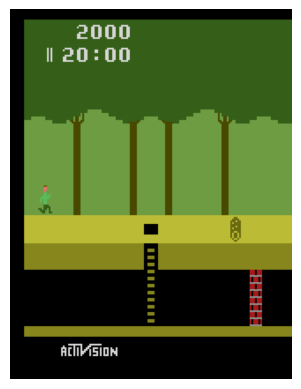

In [7]:
def show_env_info(env):
    # Print dimensions of state and action space
    print("State space: {}".format(base_env.observation_space))
    print(f"Action space: {env.action_space}")
    print(f"Action space: {env.unwrapped.get_action_meanings()}")

    # Sample random action
    action =env.action_space.sample()
    print("Action: {}".format(action))
    next_state, reward, done, _, info = env.step(action)

    # Print output
    print("Reward: {}".format(reward))
    print(f"State done :{done}")
    print(f"State info :{info}")

    # Render and plot an environment frame
    frame = env.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()

show_env_info(base_env)

# 5. Customize Environment

## Carregar modelo treinado UndergroundModel

In [8]:
model_path = 'UndergroundCNN/model.h5'
if KAGGLE:
    model_path = '/kaggle/input/' + model_path

underground_model = UndergroundModel()
underground_model.load_state_dict(torch.load(model_path))
underground_model.eval()

UndergroundModel(
  (conv1): Conv2d(3, 16, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7744, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

## 5.1 Ambiente do Modelo 1 

### Características :  

- normalização dos rewards
- observação fornecida pelo ambiente é a frame atual (ao contrário dos valores da RAM do ambiente original), resized (130x130) 
- mais rápida verificação de morte
    - verificação de frames seguidas semelhantes (algo que apenas acontece diversas vezas consecutivas no momento de morte)
- reward por entrar em salas não visitadas
    - utilizando informação da RAM 
- penalização por permanecer debaixo de terra
    - envolve resizing da imagem (130x130) para passagem para o UndergroundModel
- penalização por permanecer demasiados steps na mesma sala
- penalização por morte

Available actions: 'NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'

'RIGHT' = 'UPRIGHT' \
'LEFT' = 'UPLEFT' \
'FIRE' = 'UPFIRE', 'DOWNFIRE' \
'RIGHTFIRE' = 'UPRIGHTFIRE', 'DOWNRIGHTFIRE' \
'LEFTFIRE' = 'UPLEFTFIRE', 'DOWNLEFTFIRE' 
 
Redundant actions: 'UPRIGHT', 'UPLEFT', 'UPFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'DOWNRIGHTFIRE', 'UPLEFTFIRE', 'DOWNLEFTFIRE'

### Wrapper:

In [9]:
class CustomEnv(gymnasium.Wrapper):

    def __init__(self, env, model):
        super(CustomEnv, self).__init__(env)
        self.env = env
        self.model = model
        self.observation_space = Box(shape=(130,130,3), low=int(0), high=int(255)) # change observation space
        self.reset_values()
        self.env.action_space = gymnasium.spaces.Discrete(10)  # limit action space
        
        
    def reset_values(self):
        '''Reset environment values'''
        self.lives = 3
        self.last_room_img = None # last visited room
        self.is_zero_before = False # difference between last two frames
        self.n_zeros_before = 0 # number of consecutive similar frames
        self.latest_visited_room = 196 # id of first room
        self.steps_in_visited_rooms = 0
        self.visited_rooms = [196] # list of visited rooms
        
    def calculate_mse(self, img1, img2):
        '''Calculates similarity between images'''
        np_image1 = np.array(img1)
        np_image2 = np.array(img2)
        mse = np.mean((np_image1 - np_image2) ** 2)
        return mse
    
    def map_actions(self,action):
        '''Remaps certain actions'''
        match action:
            case 6:
                action = 11
            case 7:
                action = 12
            case _:
                pass
        return action

    def step(self, action):
        '''Override step method'''
        action = self.map_actions(action)
        next_state_ram, reward, done, truncated, info = self.env.step(action)
        # Get number of lives left
        self.lives = info['lives']
        # Get current room
        current_room_id = next_state_ram[1]
        
        # Normalizing the reward for every treasure to be worth the same
        if(reward>0):
            if(reward>2000):
                reward = 2000
            reward = reward/2000

        # Normalizing the biggest score penalty
        elif(reward<0):
            if(reward<-100):
                reward = -100
            reward = reward/100    
            
        # Get current frame
        next_state_img = self.env.render()
        # Resize frame
        next_state_img = resize(next_state_img,(130,130))

        # Predict if player is underground
        underground_prediction = self.make_underground_prediction(next_state_img)
        # Give negative reward if agent is underground
        if underground_prediction == 1:
            reward -= 0.25
        
        # Penalize agent for staying in the same room too much time (~150 steps)
        if current_room_id in self.visited_rooms:
            self.steps_in_visited_rooms += 1
            if self.steps_in_visited_rooms > 200:
                reward -= 0.15
                self.steps_in_visited_rooms = 150
        else:
            self.steps_in_visited_rooms = 0
        
        # Reward if agent discovers a new room
        if current_room_id not in self.visited_rooms:
            reward += 0.25
            self.visited_rooms.append(current_room_id)          

        # Update last visited room
        self.latest_visited_room = current_room_id

        # Giving negative reward for death
        # Try to detect death ASAP
        mse_score = None
        if self.last_room_img is not None:
            mse_score = self.calculate_mse(self.last_room_img, next_state_img)
            if mse_score == 0:
                # five identical frames corresponds to death
                if self.is_zero_before and self.n_zeros_before > 5:
                    reward -= 1
                    self.n_zeros_before = -9999
                
                self.is_zero_before = True
                self.n_zeros_before += 1
                
            else:
                self.is_zero_before = False
                self.n_zeros_before = 0

        # Normalizing rewards
        if(reward>1):
            reward = 1
        elif(reward<-1):
            reward = -1

        # Updating last room frame
        self.last_room_img = next_state_img
        return next_state_img, reward, done, truncated, info

    def reset(self,seed=None):
        '''Override the reset method'''
        if seed:
            _,info = self.env.reset(seed=seed)
        else:
            _,info = self.env.reset()
        # render needs to return a frame observation
        img = self.env.render()
        img = resize(img,(130,130))
        self.reset_values()
        return (img,info)
        

    def make_underground_prediction(self, img):
        '''Checks if player is underground'''
        img = self.preprocessar(img)
        img = img.astype(np.float32)
        img = Tensor(img)
        img = img.reshape(1,3,130,130)
        pred = self.model(img)
        pred = pred.detach().cpu().detach().numpy()[0].argmax()
        return pred

    def preprocessar(self,imagem):
        '''Process frame for the underground model'''
        imagem = np.array(imagem)
        data_mean = np.mean(imagem)
        data_std = np.std(imagem)
        imagem = (imagem - data_mean) / data_std
        xmax, xmin = imagem.max(), imagem.min()
        imagem = (imagem - xmin)/(xmax - xmin)
        imagem = imagem.transpose(2,1,0)
        return imagem

# Wrap env
env = CustomEnv(base_env, underground_model)
if env.reset():
    print('Custom Environment is ready!')

Custom Environment is ready!


## 5.2 Ambiente do Modelo 3

### Características : 

- observação fornecida pelo ambiente é a frame atual (ao contrário dos valores da RAM do ambiente original), resized (130x130)
- mais rápida verificação de morte
    - verificação de frames seguidas semelhantes (algo que apenas acontece diversas vezas consecutivas no momento de morte)
- limitação do ambiente pelo número de salas visitadas
    - quando o agente tiver visitado mais uma sala do que na iteração do ambiente anterior, o jogo termina
    - isto permite que ele mais facilmente obtenha reward positivo e assim aprenda melhor a percorrer uma sala de cada vez
    - treino mais progressivo
    - quando o ambiente termina sem o jogador ter cumprido este objetivo, o objetivo é reduzido para a quantidade de salas visitadas nesta iteração
- agente limitado a duas vidas
- reward por entrar em salas não visitadas
    - utilizando informação da RAM 
- penalização por permanecer debaixo de terra
    - envolve resizing da imagem (130x130) para passagem para o UndergroundModel
- penalização por permanecer demasiados steps na mesma sala
- penalização por morte

Available actions: 'NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'

'RIGHT' = 'UPRIGHT' \
'LEFT' = 'UPLEFT' \
'FIRE' = 'UPFIRE', 'DOWNFIRE' \
'RIGHTFIRE' = 'UPRIGHTFIRE', 'DOWNRIGHTFIRE' \
'LEFTFIRE' = 'UPLEFTFIRE', 'DOWNLEFTFIRE' 
 
Redundant actions: 'UPRIGHT', 'UPLEFT', 'UPFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'DOWNRIGHTFIRE', 'UPLEFTFIRE', 'DOWNLEFTFIRE'

### Wrapper:

In [ ]:
class CustomEnv2(gymnasium.Wrapper):

    def __init__(self, env, model):
        super(CustomEnv2, self).__init__(env)
        self.env = env
        self.model = model
        self.observation_space = Box(shape=(130,130,3), low=int(0), high=int(255))
        self.env.action_space = gymnasium.spaces.Discrete(10)
        self.reset_values()
        self.explored_rooms = 0 # number of explored rooms on the last iretarion
        
        
    def reset_values(self):
        '''Coloca os valores default do ambiente'''
        self.lives = 3
        self.last_room_img = None
        self.is_zero_before = False
        self.n_zeros_before = 0
        self.latest_visited_room = 196
        self.steps_in_same_room = 0
        self.visited_rooms = [196]
        self.last_underground_prediction = 0
        
    def calculate_mse(self, img1, img2):
        '''Calculates similarity between images'''
        np_image1 = np.array(img1)
        np_image2 = np.array(img2)
        mse = np.mean((np_image1 - np_image2) ** 2)
        return mse
    
    def map_actions(self,action):
        '''Remaps certain actions'''
        match action:
            case 6:
                action = 11
            case 7:
                action = 12
            case _:
                pass
        return action

    def step(self, action):
        '''Override step method'''
        action = self.map_actions(action)
        next_state_ram, reward, done, truncated, info = self.env.step(action)
        self.lives = info['lives']
        current_room_id = next_state_ram[1]

        # Normalizing the reward for every treasure to be worth the same
        if(reward>0):
            if(reward>2000):
                reward = 2000
            reward = reward/2000

        # Normalizing the biggest score penalty
        elif(reward<0):
            if(reward<-100):
                reward = -100
            reward = reward/100    

        next_state_img = self.env.render()
        next_state_img = resize(next_state_img,(130,130))
        underground_prediction = self.make_underground_prediction(next_state_img)
        
        if underground_prediction == 1 and self.last_underground_prediction == 1:
            reward -= 0.05
            
        self.last_underground_prediction = underground_prediction

        
        
        # Penalize for staying in the same room to much time (~100 steps)
        if current_room_id == self.latest_visited_room:
            self.steps_in_same_room += 1
            if self.steps_in_same_room > 300:
                reward -= (0.1 + (self.steps_in_same_room-100)*0.005)
        else:
            self.steps_in_same_room = 0
            if current_room_id in self.visited_rooms:
                reward -= 1
                
        # Reward if agent discovers a new room
        if current_room_id not in self.visited_rooms:
            reward += 3
            self.visited_rooms.append(current_room_id)
            
        
        self.latest_visited_room = current_room_id

        # Try to detect death ASAP
        mse_score = None
        if self.last_room_img is not None:
            mse_score = self.calculate_mse(self.last_room_img, next_state_img)
            if mse_score == 0:
                if self.is_zero_before and self.n_zeros_before > 5:
                    reward -= 0.5
                    self.n_zeros_before = -9999
                
                self.is_zero_before = True
                self.n_zeros_before += 1
                
            else:
                self.is_zero_before = False
                self.n_zeros_before = 0

        # limit number of lives to 2
        if self.lives == 1:
            done = True
            # update max explored rooms number
            self.explored_rooms = len(self.visited_rooms)

        # if agent has explored more rooms than in the last iteration, env is done
        if self.explored_rooms < len(self.visited_rooms):
            done = True
            self.explored_rooms = len(self.visited_rooms)
        
        self.last_room_img = next_state_img
        return next_state_img, reward, done, truncated, info

    def reset(self,seed=None):
        '''Override reset method'''
        if seed:
            _,info = self.env.reset(seed=seed)
        else:
            _,info = self.env.reset()
        img = self.env.render()
        img = resize(img,(130,130))
        self.reset_values()
        return (img,info)
        

    def make_underground_prediction(self, img):
        '''Checks if player is underground'''
        img = self.preprocessar(img)
        img = img.astype(np.float32)
        img = Tensor(img)
        img = img.reshape(1,3,130,130)
        pred = self.model(img)
        pred = pred.detach().cpu().detach().numpy()[0].argmax()
        return pred

    def preprocessar(self,imagem):
        '''Process the frame for the underground model'''
        imagem = np.array(imagem)
        data_mean = np.mean(imagem)
        data_std = np.std(imagem)
        imagem = (imagem - data_mean) / data_std
        xmax, xmin = imagem.max(), imagem.min()
        imagem = (imagem - xmin)/(xmax - xmin)
        imagem = imagem.transpose(2,1,0)
        return imagem

# Start env
env = CustomEnv2(base_env, underground_model)
if env.reset():
    print('Custom Environment is ready!')

# 6. Custom Model: Define and Train

## Modelo de extração de features do algoritmo

In [ ]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Flatten(),
        )
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]


        self.linear = torch.nn.Sequential(
            torch.nn.Linear(n_flatten, features_dim),
            torch.nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))


## Algoritmo de treino - PPO

In [ ]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

## Callback para guardar resultados do treino

In [ ]:
class TensorboardCallback(BaseCallback):
    def __init__(self, log_dir, save_freq, save_path, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.writer = SummaryWriter(log_dir=log_dir)
        self.save_freq = save_freq
        self.save_path = save_path

    def _on_step(self) -> bool:
        # Log training metrics
        self.writer.add_scalar("Loss", self.locals["values"].item(), self.num_timesteps)
        self.writer.add_scalar("Reward", self.locals["rewards"][0], self.num_timesteps)

        # Save model every `self.save_freq` steps
        if self.num_timesteps % self.save_freq == 0:
            self.model.save(self.save_path+f"_{self.num_timesteps}")

        return True

    def _on_training_end(self) -> None:
        # Close the SummaryWriter after training
        self.writer.close()

# Specify the log directory where TensorBoard files will be saved
log_dir = "logs/"

# Create a TensorboardCallback
tensorboard_callback = TensorboardCallback(log_dir=log_dir, save_freq=10000, save_path='(kaggle) ppo_pitfall_1M')

## Treino do modelo

In [ ]:
# Train the agent
model.learn(total_timesteps=1000000, callback=tensorboard_callback)

# Save the model
model.save("pitfall_model")

# 7. Test Model

Testar modelo:
- carregar modelo e ambiente
- modelo toma ação de acordo com o estado
- toma ações até jogo terminar
- correr e criar animação
- para correr os modelos, é pode ser usado apenas o ambiente base com observações humanas e com um wrapper que da resize do frame para 130x130
    - permite mais facilmente testar o modelo sem o limite de vidas imposto pelo wrapper do modelo 3
    - como alternativa mais simples, o modelo 3 pode ser corrido usando o wrapper do modelo 1 (porque dá resize e não tem limitação de vidas)

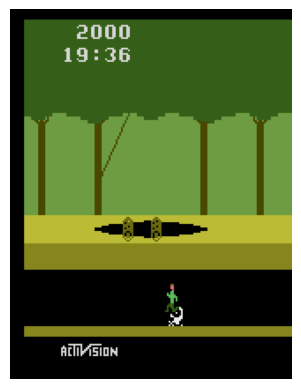

Episode: 1743/1743
Epoch: 0/0
Action: 9
Reward: 0.0
Comulative Reward: -29.0


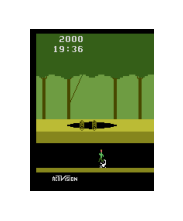

In [10]:
# Reseting the environment between tests
env = CustomEnv(base_env, underground_model)

# Loading the model
model = PPO.load("model.zip")

experience_buffer = []
obs = env.reset()[0]
com_reward = 0
terminated = False
start_time = time.time()
epoch = 0
# run while not finished, or at most 30 seconds
while not terminated:
    action, _ = model.predict(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    com_reward += reward

    experience_buffer.append({
        'episode': info['episode_frame_number'],
        'epoch': epoch,
        'frame': env.render(),
        'action': action,
        'reward': reward,
        'state': obs,
        'com_reward': com_reward,
    })
    
    obs = next_obs
    
    if time.time() - start_time > 30:
        break

run_animation(experience_buffer)
store_episode_as_gif(experience_buffer, filepath='animation.gif')